# I. Solving the system

**2 configurations :**
- système libre
- système avec forçage

**2 méthodes de résolution :**
- intégration numérique
- state space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import sys,os

import matplotlib
import matplotlib.colors as colors
import matplotlib.cm as cmx
import colorcet as cc
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib import cycler

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 14,'legend.fontsize':14})
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["axes.prop_cycle"] = cycler('color',['b', 'g', 'r', 'c', 'm', 'y', 'k'])

In [3]:
# Constantes du problème

G_hostrock = 2.1e9 # Host rock shear modulus (Pa)
nu_hostrock = 0.25 # Host rock Poisson ratio
mu_melt = 1. # Magma viscosity (Pa.s)

In [4]:
def graph_1D_N_chambers(N):
    """
    Graph 1D de N chambres magmatiques, compressibilités et conductivités constantes
    """
    
    G = nx.Graph()
    
    # 1. ajout des noeuds
    for i in range(N):
        G.add_node(i, compressibility=1)
        
    # 2. ajout des arrêtes
    for i in range(N-1):
        G.add_edge(i, i+1, conductivity=1)
        
    return G

def get_compressibility(G,i):
    """Retourne la compressibilité de la chambre i"""
    return G.nodes[i]["compressibility"]

def get_conductivity(G,i,j):
    """Retourne la conductivité du conduit entre i et j"""
    try :
        return G.get_edge_data(i,j)["conductivity"]
    except:
        return 0.
    
def plot_graph(G):

    options_nxdraw = {
        #"font_size": 36,
        #"node_size": 3000,
        "node_color": "white",
        "edgecolors": "black",
        #"linewidths": 5,
        #"width": 5,
    }
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, **options_nxdraw)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.1)
    plt.axis("off")
    

In [5]:
def build_state_space_matrix_free(G):
    """ 
    Construit à partir de la description du système sous forme de graph la matrice A telle que dx/dt = Ax
    """
    
    N = len(G)
    A = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            # Terme en i,i
            if j == i: 
                A[i,i] = - sum([get_conductivity(G,i,k) for k in range(N+1) if k != i]) / get_compressibility(G,i)
            # Terme en i,j (j!=i)
            else : 
                A[i,j] = get_conductivity(G,i,j)/get_compressibility(G,i)
        
    return A 

def build_state_space_matrix_forced(G,sources):
    """ 
    Construit à partir de la description du système sous forme de graph G les matrices A et B telles que dx/dt = Ax + Bu
    Avec u les termes de forçage 
    sources : vecteur des connectivités au terme source 
    """
    
    N = len(G)
    
    # Matrice A
    A = build_state_space_matrix_free(G)
    # Ajout du terme source 
    for i in range(N):
        A[i,i] -= sources[i]/get_compressibility(G,i)
        
    # Matrice B 
    B = np.zeros((N,N))
    B = np.diag(sources/np.array([get_compressibility(G,i) for i in range(N)]))
    
    return A,B

In [6]:
def solve_numerical_integration_free(G, p0, time_):

    # Construction matrice du système 
    A = build_state_space_matrix_free(G)
    
    # Résolution du système
    def system(p, t):
        dpdt = np.dot(A, p)
        return dpdt 

    p = odeint(system, p0, time_)
    
    return p

def solve_numerical_integration_forced(G, p0, li, p_source, time_):
    """li : connectivités à la source ; p_source : pression à la source"""
    
    # Construction matrice du système 
    A,B = build_state_space_matrix_forced(G, li)
    
    p_sources = np.array([1 if li[i]!=0 else 0 for i in range(len(G))])*p_source
    
    # Résolution du système
    def system(p, t):
        dpdt = np.dot(A, p) + np.dot(B, p_sources)
        return dpdt 

    p = odeint(system, p0, time_)
    
    return p
    

In [7]:
def exponential_compliance_time(A, t):
    n_nodes = A.shape[0]
    # eigendecomposition of A
    D, T = np.linalg.eig(A) # /!\ we need to use eig (instead of eigh) because A is no longer symmetric /!\
    tol = 1e-9
    D[np.where(np.abs(D)<tol)]=0.
    # compute matrix exponential using : e^{At}=T*e^{Dt}*T^{-1}
    Tinv = np.linalg.inv(T)
    eDt = np.exp(np.array((t[:][:, np.newaxis, np.newaxis]*D), dtype=float))*np.eye(n_nodes) # use broadcasting
    eDtTinv = np.dot(eDt, Tinv)
    eAt = np.dot(eDtTinv.transpose((0,2,1)),(T.T)).transpose((0,2,1)) 
    return eAt

In [8]:
def solve_analytically_free(G, p0, time_):
    
    n_sills = len(G)
    
    A = build_state_space_matrix_free(G)
    
    # Résolution p(t)
    eAt = exponential_compliance_time(A, time_)
    p = np.dot(eAt,p0.T).reshape(-1, n_sills)
    
    # Calcul des pressions à t_inf
    D, T = np.linalg.eig(A) # /!\ now we need to use eig (instead of eigh) because A is no longer symmetric /!\
    Tinv = np.linalg.inv(T)
    
    # Index corresponding to null eigenvalue
    index_null_eigenvalue = np.where(np.abs(D)<1e-14)[0]
    
    # e^{Dt} for t -> infty should have zeros everywhere, except for the null eigenvalue
    eDtinf = np.zeros((n_sills, n_sills))
    eDtinf[index_null_eigenvalue, index_null_eigenvalue] = 1
    
    # Compute pressure accordingly
    p_inf = np.dot( np.dot(T, np.dot(eDtinf, Tinv)), p0.T).reshape(n_sills)
    
    return p,p_inf
    
def solve_analytically_forced(G, p0, li, p_source, time_):
    
    n_sills = len(G)
    
    A,B = build_state_space_matrix_forced(G,li)
    
    p_sources = np.array([1 if li[i]!=0 else 0 for i in range(len(G))])*p_source
    u = p_sources
    
    ### Time step
    h = time_[1]-time_[0]
    k_stop = int(((time_[-1]-time_[0])/h)+2)
    k = np.array(range(time_.shape[0]))

    #### Build matrix $A_d=e^{Ah}$
    Ad = exponential_compliance_time(A, np.array([h])).reshape(n_sills,n_sills) # = e^{hA}
    
    #### Build matrix $B_d=A^{-1}.(A_d-I).B$ 
    Ainv = np.linalg.inv(A) # we will need this one too
    Bd = np.dot(np.dot(Ainv, (Ad - np.eye(A.shape[0]))), B) # = A^{-1}*(e^{hA}-I)*B
    
    #### Iterative solution: $x_d(k+1)=A_d.x_d(k)+B_d.u_d(k)$
    
    xditer = np.zeros((len(k), A.shape[0]))
    
    # Initilisation
    xditer[0,:] = p0
    
    # Itération
    for _k in k[1:]:
        xditer[_k,:] = (np.dot(Ad, xditer[_k-1,:]).T + np.dot(Bd, u)).reshape(-1)
    
    p = xditer
    return p 

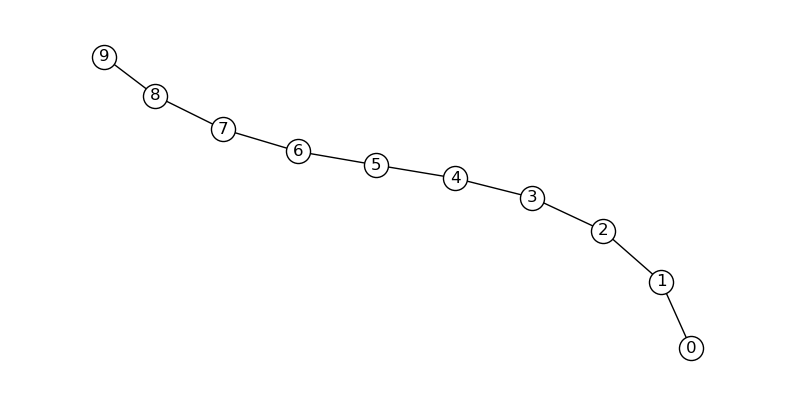

In [9]:
# Définition du graphe
N = 10
G = graph_1D_N_chambers(N) 

plot_graph(G)

In [10]:
# Cas libre
p0 = np.zeros(N)
p0[0] = 1e6 # Chambre n°0 initiallement à 1MPa

# Solve numerically
t_stop = 40
time = np.linspace(0.,t_stop,1000)
p_numInt = solve_numerical_integration_free(G, p0, time)

p,p_inf = solve_analytically_free(G, p0, time)

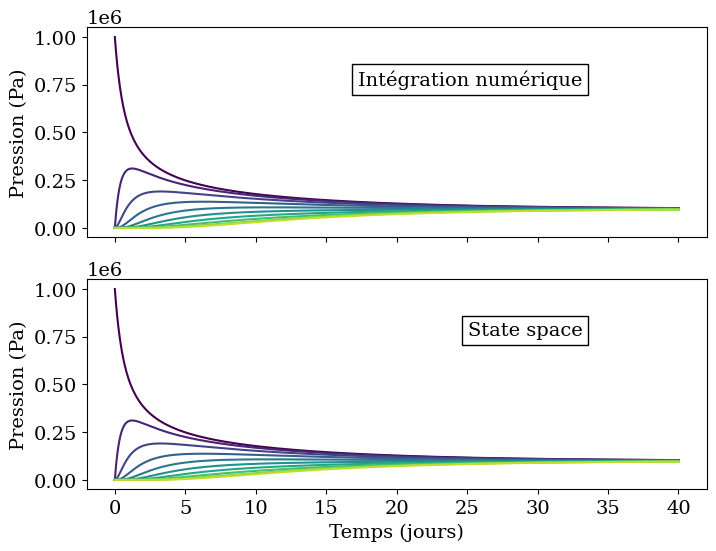

In [11]:
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=N), cmap='viridis')
color_map2 = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=N), cmap='bone')

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

for i in range(N):
    ax1.plot(time, p_numInt[:,i], color=color_map.to_rgba(i), label='%d' % i)
    ax2.plot(time, p[:,i], color=color_map.to_rgba(i), label='%d' % i)
    
ax2.set_xlabel("Temps (jours)")
ax1.set_ylabel("Pression (Pa)")
ax2.set_ylabel("Pression (Pa)")

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax1.text(0.8, 0.8,"Intégration numérique",transform=ax1.transAxes, verticalalignment='top', bbox=box_props,horizontalalignment="right")
ax2.text(0.8, 0.8,"State space",transform=ax2.transAxes, verticalalignment='top', bbox=box_props,horizontalalignment="right")


# ax2.axhline(p_inf[0], c="k",lw=1.5, ls='dotted')
# ax1.set_title("Intégration numérique")
# ax2.set_title("Solution exacte")

plt.savefig("./figures_pdf/ss_vs_intnum_free.pdf",bbox_inches='tight')

plt.show()

In [12]:
# Cas forçage externe : seule la première chambre est connectée à la source
source = np.zeros(N)
source[0] = 1
p_source = 1e6
p0 = np.zeros(N)

t_stop = 200
time = np.linspace(0.,t_stop,1000)
p_numInt = solve_numerical_integration_forced(G, p0, source, p_source, time)
p = solve_analytically_forced(G, p0, source, p_source, time)


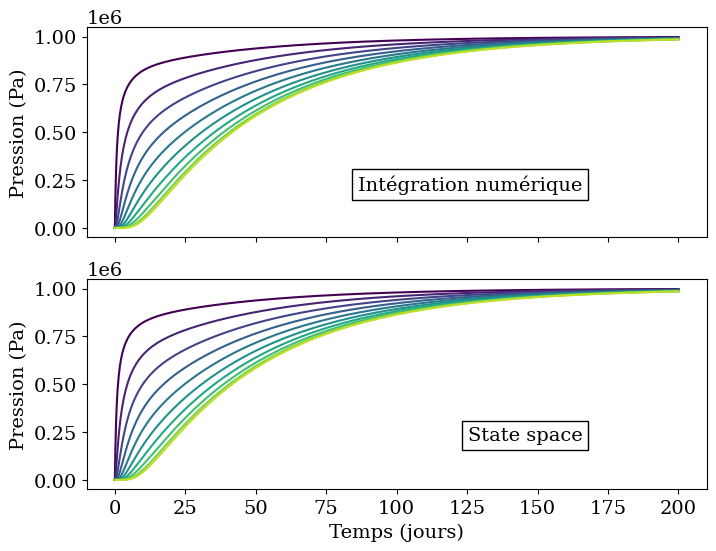

In [13]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

for i in range(N):
    ax1.plot(time, p_numInt[:,i], color=color_map.to_rgba(i), label='%d' % i)
    ax2.plot(time, p[:,i], color=color_map.to_rgba(i), label='%d' % i)
    
# ax2.axhline(p_inf[0], c="k",lw=1.5, ls='dotted')

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax1.text(0.8, 0.3,"Intégration numérique",transform=ax1.transAxes, verticalalignment='top', bbox=box_props,horizontalalignment="right")
ax2.text(0.8, 0.3,"State space",transform=ax2.transAxes, verticalalignment='top', bbox=box_props,horizontalalignment="right")


ax2.set_xlabel("Temps (jours)")
ax1.set_ylabel("Pression (Pa)")
ax2.set_ylabel("Pression (Pa)")

plt.savefig("./figures_pdf/ss_vs_intnum_forced.pdf",bbox_inches='tight')

plt.show()

# II. géometrie du système

In [14]:
# Random number generator
randomgen=np.random.default_rng(2000) # fixed seed, for reproductibility
#randomgen=np.random.default_rng() # uncomment for truly random results

In [15]:
# Paramètres 
n_sills = 10 
volume_depth_top = 3. ; volume_depth_bottom = 30. 
volume_radius = 1. # pas utilisé directement, voir r_rnd_normal_std

r_rnd_normal_mean = 0. ; r_rnd_normal_std = 1.0
t_rnd_unif_min = 0.; t_rnd_unif_max = 2*np.pi
R_rnd_lognormal_mean = 0.; R_rnd_lognormal_std = 0.2
R_rnd_lognormal_scale = 1; # Radius of sills

In [16]:
# Détermination des connections

def barycenter(x1, R1, x2, R2):
    return (R1*x2 + R2*x1)/(R1+R2)

def make_sill_connections(sills_xyzR):
    
    conduit_xyzz = []
    
    for i in range(n_sills): # loop over sills, assuming that sills are sorted in decreasing order of depth
        xi, yi, zi, Ri = sills_xyzR[i,:]
        
        for j in range(i+1, n_sills): # loop over other sills above
            xj, yj, zj, Rj = sills_xyzR[j,:]
            
            dij = np.sqrt((xj-xi)**2+(yj-yi)**2) # distance between sill centers
            if dij < Ri + Rj: # the two sills have an intersection
                xa, ya = barycenter(np.array([xi,yi]), Ri, np.array([xj,yj]), Rj) # coordinates of connection between the sills
                
                test_intersect = False
                for k in range(i+1, j): # check if connection intersects a third sill
                    xk, yk, zk, Rk = sills_xyzR[k,:]
                    dka = np.sqrt((xk-xa)**2+(yk-ya)**2) # distance between connection and third sill
                    #print("  Check: i=%d (%.2f) ; j=%d (%.2f) ; k=%d (%.2f)" % (i,Ri,j,Rj,k,Rk))
                    if dka < Rk: # connection intersects the third sill
                        test_intersect = True # intersection: ignore connection
                        break
                    
                if not(test_intersect): # no intersection: append connection
                    conduit_xyzz.append([i, j, xa, ya, zi, zj])
                    
    return np.array(conduit_xyzz)

In [17]:
# Tirage aléatoire des sills

r_rnd = np.abs(randomgen.normal(r_rnd_normal_mean, r_rnd_normal_std, n_sills))
t_rnd = randomgen.uniform(t_rnd_unif_min, t_rnd_unif_max, n_sills)
z_rnd = randomgen.uniform(volume_depth_top, volume_depth_bottom, n_sills)
R_rnd = R_rnd_lognormal_scale * randomgen.lognormal(R_rnd_lognormal_mean, R_rnd_lognormal_std, n_sills) 

x_rnd = r_rnd * np.cos(t_rnd)
y_rnd = r_rnd * np.sin(t_rnd)

sills_xyzR = np.vstack([x_rnd,y_rnd,z_rnd,R_rnd]).T

# Sort by decreasing depth
sills_xyzR = sills_xyzR[sills_xyzR[:,2].argsort()][::-1]

In [18]:
conduits_xyzz = make_sill_connections(sills_xyzR)

In [19]:
from utilities import plot_3D_geometry

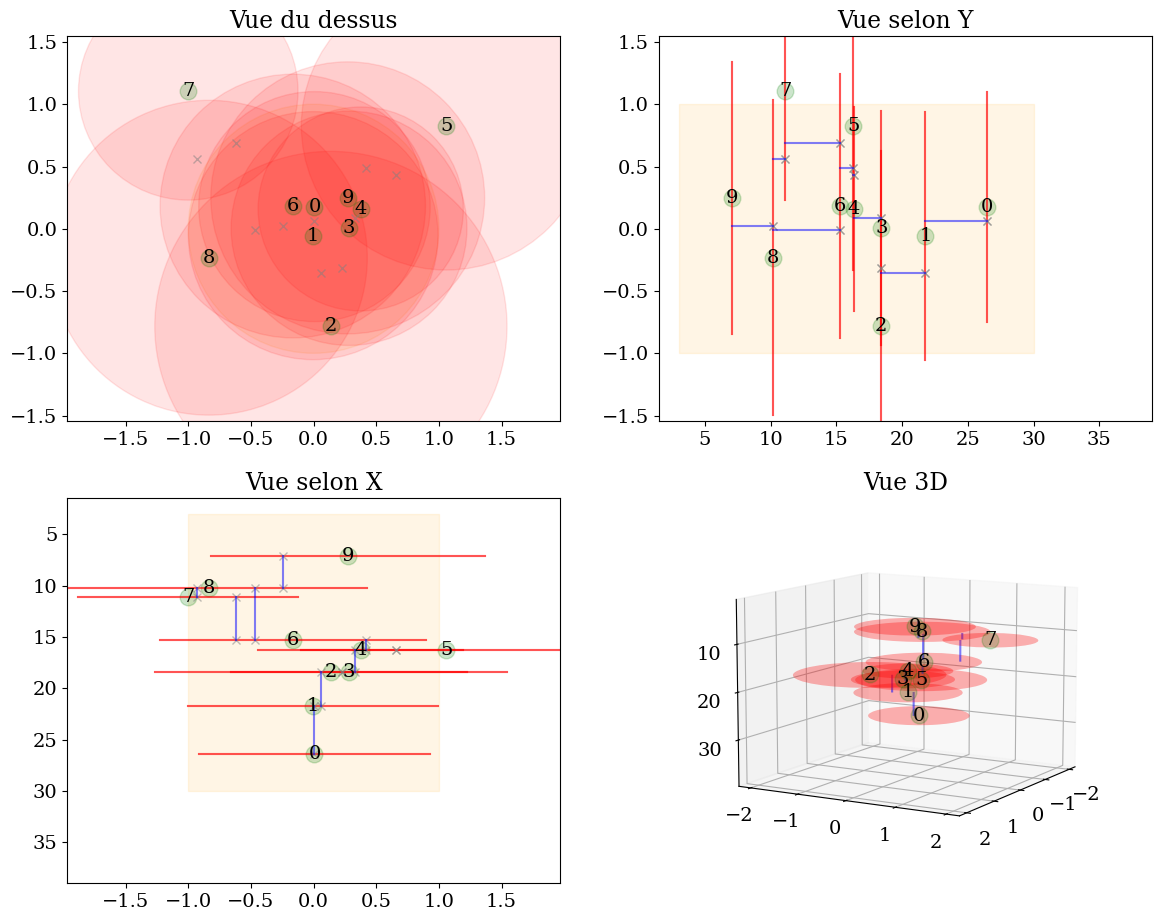

In [20]:
fig,axes = plot_3D_geometry(sills_xyzR,conduits_xyzz,volume_depth_top,volume_depth_bottom,volume_radius)
plt.savefig("./figures/exemple_geometrie.pdf",bbox_inches='tight')
plt.show()

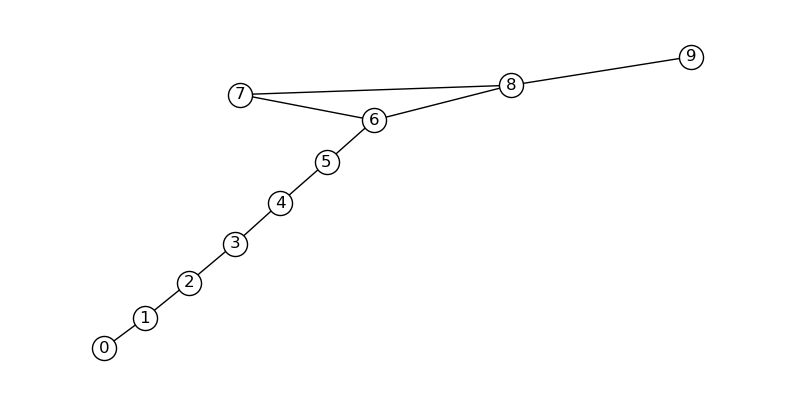

In [22]:
# Construction du graph associé 

def build_graph(sills_xyzR, conduits_xyzz):
    
    n_sills = sills_xyzR.shape[0]

    G = nx.Graph()

    # 1. ajout des noeuds
    
    gamma_hostrock = 8*(1-nu_hostrock)/(3*np.pi)
    
    for i in range(n_sills):
        G.add_node(i, compressibility = np.pi*(sills_xyzR[i,3]*1e3)**3*gamma_hostrock/G_hostrock)
        
    # 2. ajout des arrêtes
    
    radius_conduits = 1.
    
    for i,j,_,_,zi,zj in conduits_xyzz:
        i,j = int(i),int(j)
        height_conduit = np.abs(zj-zi)*1e3
        G.add_edge(i,j,conductivity = np.pi*radius_conduits**4/(8*mu_melt*height_conduit))

    return G

G = build_graph(sills_xyzR,conduits_xyzz)
plot_graph(G)

plt.savefig("./figures/exemple_geometrie_associated_graph.pdf",bbox_inches='tight')

## III. Calcul des déformations

In [23]:
# Importation of VSM codes
sys.path.append('/home/sbrisson/documents/IPGP/projet_tutore/magma_chambers_network/VSM/VSM')
import VSM_forward, VSM_utilities

In [24]:
def sill_deform_pointsource(xg, yg, xs, ys, zs, Rs, p, mu_rigidity = 2.1e9, Poisson = 0.25):
    k = float((Rs**3)*(4/np.pi)*p*(1-Poisson)/mu_rigidity)
    R = np.sqrt((xs-xg)**2+(ys-yg)**2+zs**2)
    ux = k*(zs**2)/(R**5)*(xg-xs)
    uy = k*(zs**2)/(R**5)*(yg-ys)
    uz = k*(zs**2)/(R**5)*(zs*np.ones(xg.shape))
    return ux, uy, uz

def mogi_deform_pointsource(xg, yg, xs, ys, zs, Rs, p, mu_rigidity = 2.1e9, Poisson = 0.25):
    k = float((Rs**3)*p*(1-Poisson)/mu_rigidity)
    R = np.sqrt((xs-xg)**2+(ys-yg)**2+zs**2)
    ux = k/(R**3)*(xg-xs)
    uy = k/(R**3)*(yg-ys)
    uz = k/(R**3)*(zs*np.ones(xg.shape))
    return ux, uy, uz

[]

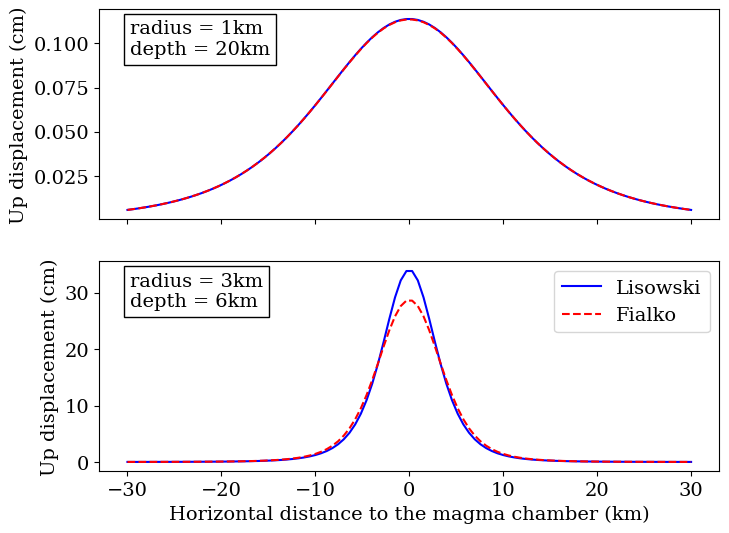

In [25]:
# Comparaison des 3 

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(8,6))

# Config 1
zs = 20e3
Rs = 1e3
xg = np.linspace(-30e3, 30e3, 100)
yg = np.zeros(100)
pressure_sill = 1e6

ux_sillpoint, uy_sillpoint, uz_sillpoint = sill_deform_pointsource(xg, yg, 0., 0., zs, Rs, pressure_sill)
ux_fialko, uy_fialko, uz_fialko = VSM_forward.fialko(xg.reshape(-1), yg.reshape(-1), 0., 0., zs, Rs, pressure_sill/G_hostrock, nu_hostrock)
ux_mogi, uy_mogi, uz_mogi = mogi_deform_pointsource(xg, yg, 0., 0., zs, Rs, pressure_sill)

# ax1.plot(xg*1e-3, 100*uz_mogi, label="Mogi")
ax1.plot(xg*1e-3, 100*uz_sillpoint, label="Penny-shaped crack",c="b")
ax1.plot(xg*1e-3, 100*uz_fialko, label="Fialko",ls="--",c="r")

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax1.text(
    0.05, 0.95,
    f"radius = {Rs*1e-3:.0f}km"+"\n"+f"depth = {zs*1e-3:.0f}km",
    transform=ax1.transAxes, verticalalignment='top', bbox=box_props
    )

ax1.set_ylabel("Up displacement (cm)")

# Config 2
zs = 6e3
Rs = 3e3
xg = np.linspace(-30e3, 30e3, 100)
yg = np.zeros(100)
pressure_sill = 1e6

ux_sillpoint, uy_sillpoint, uz_sillpoint = sill_deform_pointsource(xg, yg, 0., 0., zs, Rs, pressure_sill)
ux_fialko, uy_fialko, uz_fialko = VSM_forward.fialko(xg.reshape(-1), yg.reshape(-1), 0., 0., zs, Rs, pressure_sill/G_hostrock, nu_hostrock)
ux_mogi, uy_mogi, uz_mogi = mogi_deform_pointsource(xg, yg, 0., 0., zs, Rs, pressure_sill)

# ax2.plot(xg*1e-3, 100*uz_mogi, label="Mogi")
ax2.plot(xg*1e-3, 100*uz_sillpoint, label="Lisowski",c="b")
ax2.plot(xg*1e-3, 100*uz_fialko, label="Fialko",ls="--",c="r")

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax2.text(
    0.05, 0.95,
    f"radius = {Rs*1e-3:.0f}km"+"\n"+f"depth = {zs*1e-3:.0f}km",
    transform=ax2.transAxes, verticalalignment='top', bbox=box_props
    )

ax2.set_ylabel("Up displacement (cm)")


ax2.set_xlabel("Horizontal distance to the magma chamber (km)")
ax2.legend()
plt.savefig("./figures/comparaison_modele_def_2.pdf",bbox_inches='tight')
plt.plot()

In [26]:
# Grid
x_step = 0.2e3
x_min = -15.e3
x_max = 15.e3
n_x = int((x_max-x_min)/x_step) + 1
xi = yi = np.linspace(x_min, x_max, n_x)
xg, yg = np.meshgrid(xi, yi)

# Stations
n_stations = 40
x_stations = randomgen.uniform(x_min,x_max,n_stations)
y_stations = randomgen.uniform(x_min,x_max,n_stations)

# Test code Fialko 2001
# Source location
xs, ys, zs, Rs = 3.2e3, -7.4e3, 3.6e3, 3.e3
hs = zs/Rs
print(hs)
row_index = int((x_max+ys)/x_step)
col_index = int((x_max+xs)/x_step)
print(col_index, row_index)

pressure_sill = 1e6
radius = 1e3
dP_mu = pressure_sill / G_hostrock
dVol = VSM_utilities.volume_var_penny(dP_mu,radius,nu_hostrock)
print('Volume variation of the penny-shaped crack',dVol/1e6,' 10e6 m3')

1.2
91 38
Volume variation of the penny-shaped crack 0.9523809523809524  10e6 m3


In [27]:
# Calcul pour Fialko
ux_fialko, uy_fialko, uz_fialko = VSM_forward.fialko(xg.reshape(-1), yg.reshape(-1), xs, ys, zs, Rs, pressure_sill/G_hostrock, nu_hostrock)
ux_fialko = ux_fialko.reshape(xg.shape)
uy_fialko = uy_fialko.reshape(xg.shape)
uz_fialko = uz_fialko.reshape(xg.shape)

# Calcul données INSAR
alpha = 12.
theta = 30.
wl = 0.2 # lambda = 5.5cm

n = np.array([np.sin(theta*np.pi/180)*np.cos(theta*np.pi/180), np.sin(theta*np.pi/180)*np.sin(theta*np.pi/180), np.cos(theta*np.pi/180)])

d_los = ux_fialko*n[0] + uy_fialko*n[1] + uz_fialko*n[2]

ux_stations, uy_stations, uz_stations = VSM_forward.fialko(x_stations, y_stations, xs, ys, zs, Rs, pressure_sill/G_hostrock, nu_hostrock)

uz_fialko.max()

0.6744159572810123

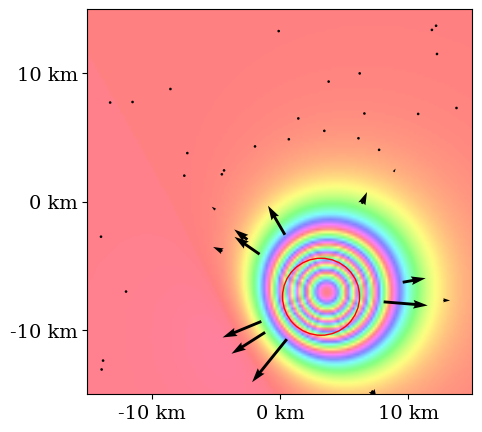

In [28]:
opts_sill_compare={'extent': (x_min*1e-3,x_max*1e-3,x_min*1e-3,x_max*1e-3), 'cmap': "hsv", 'origin': 'lower', "interpolation":"bilinear", "interpolation_stage":"rgba"}

fig, ax = plt.subplots(figsize=(5,5))

im = ax.imshow(np.mod(d_los,wl/2),alpha=0.5, **opts_sill_compare)

ax.add_patch(plt.Circle((xs/1000, ys/1000), Rs/1000, color='r',fill=False))
ax.quiver(x_stations*1e-3,y_stations*1e-3,ux_stations,uy_stations,scale=1)


ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x:.0f} km"))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x:.0f} km"))
ax.set_yticks([-10, 0, 10])
ax.set_xticks([-10, 0, 10])

plt.savefig("./figures/gnss_insar_example.pdf",bbox_inches='tight')

plt.show()

# Comparaison point source vs Fialko

# Calcul pour point source 
ux_sillpoint, uy_sillpoint, uz_sillpoint = sill_deform_pointsource(xg, yg, xs, ys, zs, Rs, pressure_sill)

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))

axs[0,0].imshow(ux_sillpoint, **opts_sill_compare)
axs[0,1].imshow(uy_sillpoint, **opts_sill_compare)
im0 = axs[0,2].imshow(uz_sillpoint, **opts_sill_compare)

axs[1,0].imshow(ux_fialko, **opts_sill_compare)
axs[1,1].imshow(uy_fialko, **opts_sill_compare)
im1 = axs[1,2].imshow(uz_fialko, **opts_sill_compare)

axs[2,0].imshow(ux_sillpoint-ux_fialko, **opts_sill_compare)
axs[2,1].imshow(uy_sillpoint-uy_fialko, **opts_sill_compare)
im2 = axs[2,2].imshow(uz_sillpoint-uz_fialko, **opts_sill_compare)

for ax in axs.reshape(-1):
    ax.axhline(ys, ls='--', c='grey', lw='0.8')
    ax.axvline(xs, ls='--', c='grey', lw='0.8')
    ax.scatter(xs,ys, s=2, c='k')

plt.colorbar(im0, ax=axs[0,2],fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=axs[1,2],fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axs[2,2],fraction=0.046, pad=0.04)

plt.show()

# Putting it all together

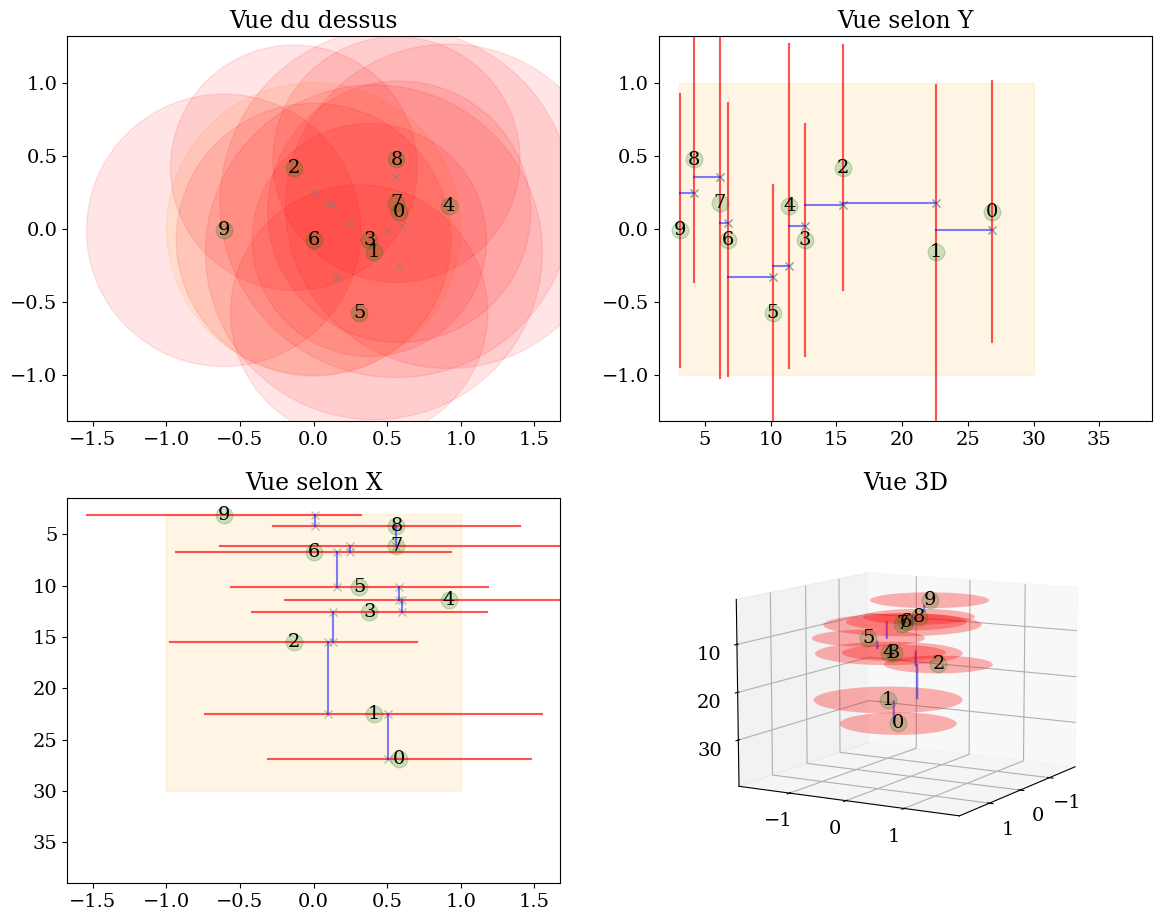

In [29]:
# 1. Construction du réseau 
# Random number generator
randomgen=np.random.default_rng(3000) # fixed seed, for reproductibility

# Tirage aléatoire des sills

r_rnd = np.abs(randomgen.normal(r_rnd_normal_mean, r_rnd_normal_std, n_sills))
t_rnd = randomgen.uniform(t_rnd_unif_min, t_rnd_unif_max, n_sills)
z_rnd = randomgen.uniform(volume_depth_top, volume_depth_bottom, n_sills)
R_rnd = R_rnd_lognormal_scale * randomgen.lognormal(R_rnd_lognormal_mean, R_rnd_lognormal_std, n_sills) 

x_rnd = r_rnd * np.cos(t_rnd)
y_rnd = r_rnd * np.sin(t_rnd)

sills_xyzR = np.vstack([x_rnd,y_rnd,z_rnd,R_rnd]).T

# Sort by decreasing depth
sills_xyzR = sills_xyzR[sills_xyzR[:,2].argsort()][::-1]

# Connection des sills
conduits_xyzz = make_sill_connections(sills_xyzR)

fig,axes = plot_3D_geometry(sills_xyzR,conduits_xyzz,volume_depth_top,volume_depth_bottom,volume_radius)
plt.show()
plt.show()


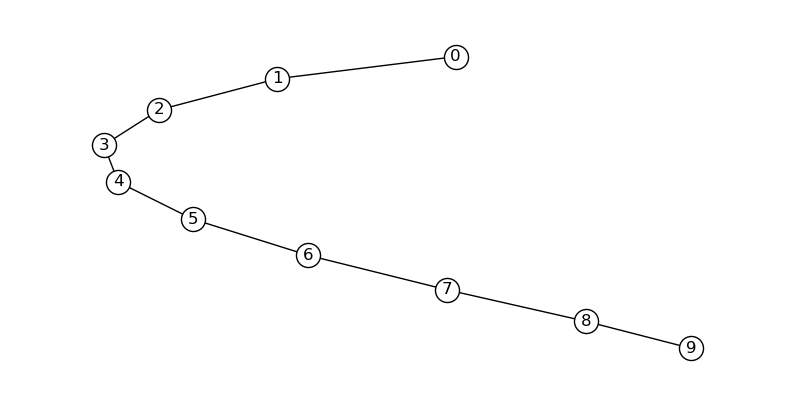

In [30]:
# 2. Construction du graph 

G = build_graph(sills_xyzR,conduits_xyzz)
plot_graph(G)

In [31]:
# 3. Résolution du système (actif : chambre la plus profonde soumise à un incrément de pression)

source = np.zeros(N)
source[0] = 1
p_source = 1e6
p0 = np.zeros(N)

t_stop = 3600*24*14
time = np.linspace(0.,t_stop,1000)
p = solve_analytically_forced(G, p0, source, p_source, time)

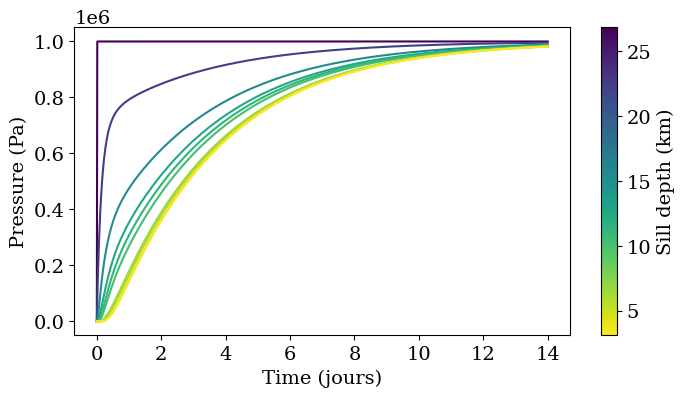

In [32]:
depths = sills_xyzR[:,2]
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=depths[-1], vmax=depths[0]), cmap='viridis_r')

fig,ax = plt.subplots(1,1,figsize=(8,4))

for i in range(N):
    ax.plot(time/24/3600, p[:,i], color=color_map.to_rgba(depths[i]), label='%d' % i)
    
plt.colorbar(color_map,ax=ax, label="Sill depth (km)")
ax.set_xlabel("Time (jours)")
ax.set_ylabel("Pressure (Pa)")

plt.show()


In [33]:
# 4. Calcul des champs de déformation en surface engendrés

# 4.2 Calcul de series temporelles 

stations_xy = np.array([[0.,0.]])
xr,yr = stations_xy[:,0],stations_xy[:,1]
n_stations =  stations_xy.shape[0]
n_time,n_sills = p.shape

uxyz_stations_sills_time = np.zeros((3,n_stations,n_sills,n_time))
for p_idx in range(n_sills):
    xs,ys,zs,Rs = sills_xyzR[p_idx,:]
    for it in range(n_time):
        
        # print("\r" + f"Itération {p_idx*n_time+it}/{n_sills*n_time} ({p_idx*n_time+it/(n_sills*n_time)*100:.2f}%)", end="")
        
        dp = p[it,p_idx]
        # Fialko -> trop long
        # ux_fialko, uy_fialko, uz_fialko = VSM_forward.fialko(xr, yr, xs, ys, zs, Rs, dp/G_hostrock, nu_hostrock)
        # uxyz_stations_sills_time[0,:,p_idx,it] = ux_fialko        
        # uxyz_stations_sills_time[1,:,p_idx,it] = uy_fialko        
        # uxyz_stations_sills_time[2,:,p_idx,it] = uz_fialko
        
        ux_point, uy_point, uz_point = sill_deform_pointsource(xr, yr, xs, ys, zs, Rs, dp)
        uxyz_stations_sills_time[0,:,p_idx,it] = ux_point        
        uxyz_stations_sills_time[1,:,p_idx,it] = uy_point        
        uxyz_stations_sills_time[2,:,p_idx,it] = uz_point

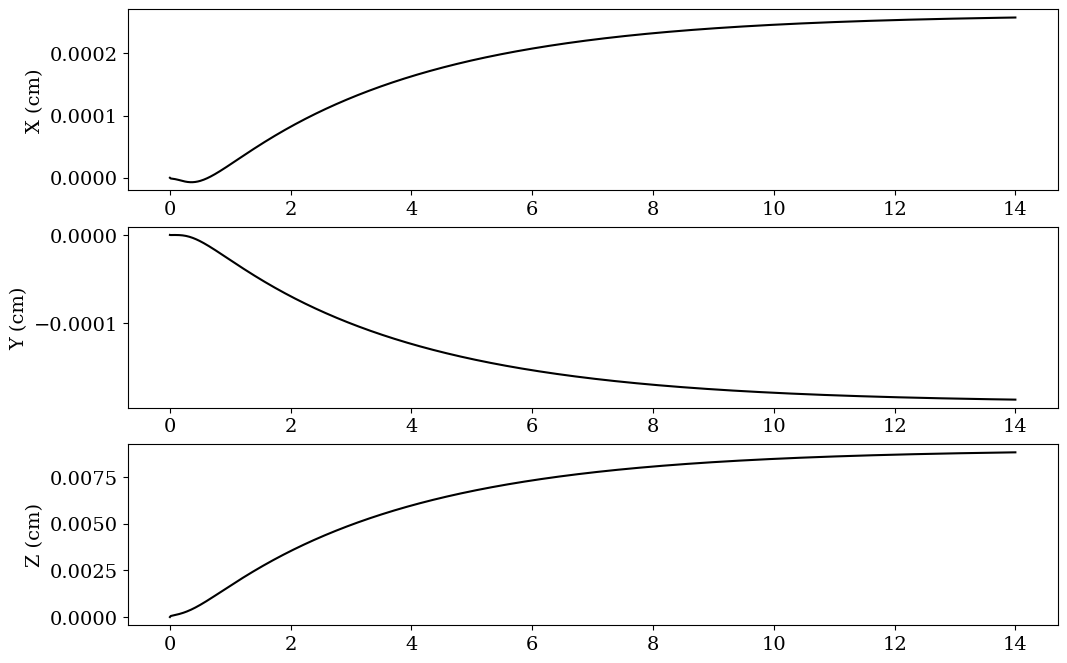

In [34]:
uxyz_stations_time = uxyz_stations_sills_time.sum(axis=2)

i_station = 0
ux,uy,uz = uxyz_stations_time[0,i_station,:],uxyz_stations_time[1,i_station,:],uxyz_stations_time[2,i_station,:]

fig, ax = plt.subplots(3, 1, figsize=(12,8)) #figsize=plt.figaspect(1), dpi=200.)

for i,(u,u_label) in enumerate(zip([ux,uy,uz],["X (cm)","Y (cm)","Z (cm)"])):
    ax[i].plot(time/24/3600, u*100 ,c="k")
    ax[i].set_ylabel(u_label)
    
# fig.suptitle(f"Déformation en x={X[x]:.0f}m y={Y[y]:.0f}m")
plt.show()

In [35]:
# Calcul des volumes²
volumes = np.pi*(1-nu_hostrock)*8/(3*np.pi*G_hostrock) * (sills_xyzR[:,3]*1e3)**3 * p

/tmp/ipykernel_25183/2008970905.py:3: RuntimeWarning: invalid value encountered in divide
  uxyz_rel_stations_sills_time = np.divide(uxyz_stations_sills_time, uxyz_stations_time[:, :, np.newaxis, :])


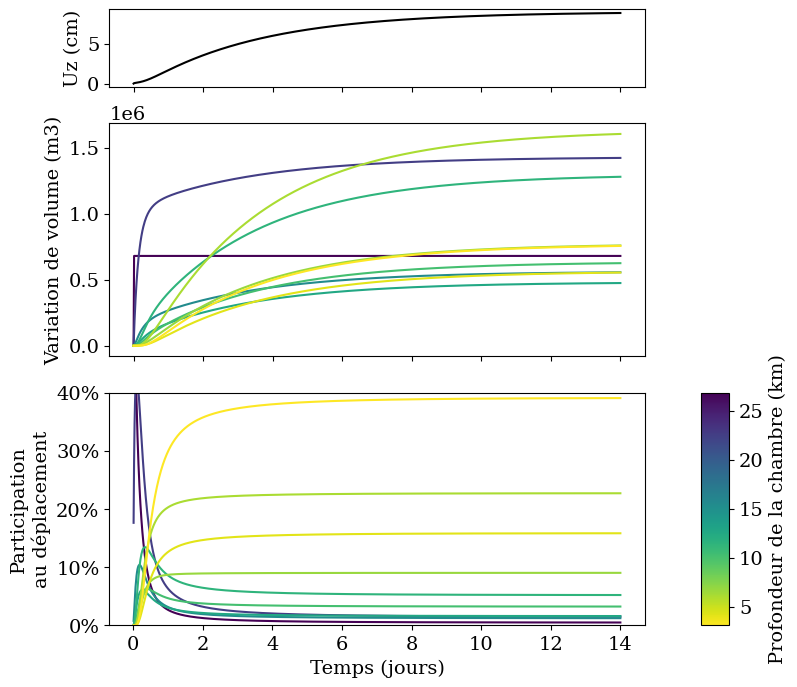

In [37]:
# Participation relative au déplacement 

uxyz_rel_stations_sills_time = np.divide(uxyz_stations_sills_time, uxyz_stations_time[:, :, np.newaxis, :])

depths = sills_xyzR[:,2]
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=depths[-1], vmax=depths[0]), cmap='viridis_r')

#fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios': [1, 3]})
kw = {'height_ratios':[1,3,3], "width_ratios":[95,5]}
fig, ((ax1, aux),(ax2,cax2),(ax3,cax)) = plt.subplots(3,2,figsize=(8,8),gridspec_kw=kw)

ax1.plot(time/(24*3600),uxyz_stations_time[2,i_station,:]*1e5,"k")
ax1.set_ylabel("Uz (cm)")

for i in range(N):
    ax2.plot(time/24/3600, volumes[:,i], color=color_map.to_rgba(depths[i]), label='%d' % i)
ax2.set_ylabel("Variation de volume (m3)")

for i in range(n_sills):
    uz = uxyz_rel_stations_sills_time[2,i_station,i,:]
    ax3.plot(time/(24*3600), uz*100, color=color_map.to_rgba(depths[i]), label='%d' % i)

ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/100:.0%}'))
ax3.set_ylabel("Participation\nau déplacement")
ax3.set_xlabel("Temps (jours)")
ax3.set_ylim(0,40)

fig.colorbar(color_map, cax=cax, label="Profondeur de la chambre (km)")
aux.axis("off")
cax2.axis("off")

# Hide xtick labels on ax1
ax1.tick_params(axis="x", labelbottom=False)
ax2.tick_params(axis="x", labelbottom=False)

plt.savefig("./figures_pdf/participation_deplacement.pdf",bbox_inches='tight')

plt.show()

/tmp/ipykernel_7723/1582389233.py:3: RuntimeWarning: invalid value encountered in divide
  uxyz_rel_stations_sills_time = np.divide(uxyz_stations_sills_time, uxyz_stations_time[:, :, np.newaxis, :])


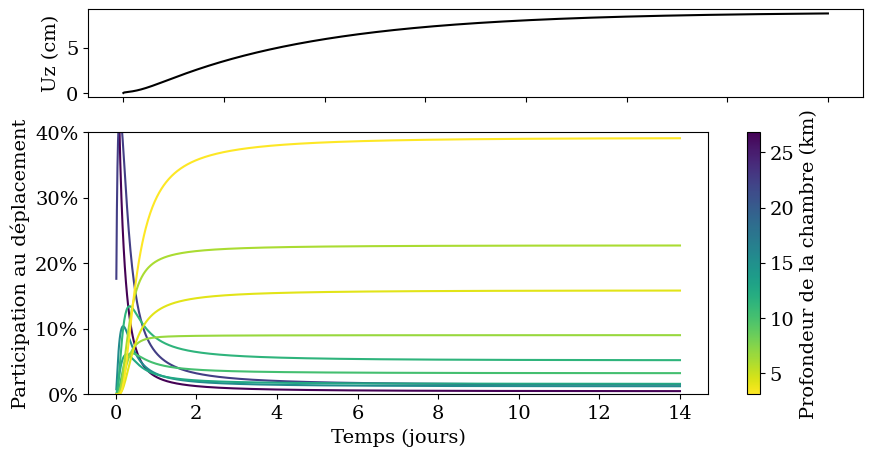

In [70]:
# Participation relative au déplacement 

uxyz_rel_stations_sills_time = np.divide(uxyz_stations_sills_time, uxyz_stations_time[:, :, np.newaxis, :])

depths = sills_xyzR[:,2]
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=depths[-1], vmax=depths[0]), cmap='viridis_r')

fig,(ax1,ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 3]})

ax1.plot(time/(24*3600),uxyz_stations_time[2,i_station,:]*1e5,"k")
ax1.set_ylabel("Uz (cm)")

for i in range(n_sills):
    uz = uxyz_rel_stations_sills_time[2,i_station,i,:]
    ax2.plot(time/(24*3600), uz*100, color=color_map.to_rgba(depths[i]), label='%d' % i)

ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/100:.0%}'))
ax2.set_ylabel("Participation au déplacement")
ax2.set_xlabel("Temps (jours)")
ax2.set_ylim(0,40)
ax1.tick_params(axis="x", labelbottom=False)
plt.colorbar(color_map, ax=ax2,label="Profondeur de la chambre (km)")
plt.savefig("./figures_inversion_pdf/participation_deplacement.pdf")

plt.show()
